In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv('movies_metadata.csv', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [2]:
# 상위 2만개의 샘플을 data에 저장
data = data.head(20000)

In [3]:
# overview 열에 존재하는 모든 결측값을 전부 카운트하여 출력
print('overview 열의 결측값의 수:',data['overview'].isnull().sum())

overview 열의 결측값의 수: 135


In [4]:
# 결측값을 빈 값으로 대체
data['overview'] = data['overview'].fillna('')

In [5]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print('TF-IDF 행렬의 크기(shape) :',tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (20000, 47487)


In [6]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (20000, 20000)


In [7]:
title_to_index = dict(zip(data['title'], data.index))

# 영화 제목 Father of the Bride Part II의 인덱스를 리턴
idx = title_to_index['Father of the Bride Part II']
print(idx)

4


In [8]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다.
    idx = title_to_index[title]

    # 해당 영화와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 10개의 영화를 받아온다.
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 영화의 인덱스를 얻는다.
    movie_indices = [idx[0] for idx in sim_scores]

    # 가장 유사한 10개의 영화의 제목을 리턴한다.
    return data['title'].iloc[movie_indices]

In [9]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

In [10]:
def get_recommendations_for_overview(overview, cosine_sim=cosine_sim):
    # Transform the provided overview with the existing TF-IDF model
    overview_tfidf = tfidf.transform([overview])

    # Compute the cosine similarity between the provided overview and all movie overviews
    sim_scores = cosine_similarity(overview_tfidf, tfidf_matrix).flatten()

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(list(enumerate(sim_scores)), key=lambda x: x[1], reverse=True)

    # Get the scores for the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data['title'].iloc[movie_indices]


In [11]:
A group of friends embark on a fun adventure determined to find a college roommatget_recommendations_for_overview("e who disappeared without a trace on graduation day.")

6247                                           For Sale
14747                                       Defenseless
1524                                       Career Girls
17064                                       Kill Theory
19152                              Balto II: Wolf Quest
3323                                      Born American
4282                                     Something Wild
17240                                   Calvin Marshall
12450    VeggieTales: The Pirates Who Don't Do Anything
16567                        Short Night of Glass Dolls
Name: title, dtype: object

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [13]:
# Drop rows with missing values in the 'overview' or 'vote_average' columns
data = data.dropna(subset=['overview', 'vote_average'])

# Split data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Vectorize the 'overview' text
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_data['overview'])
X_test = vectorizer.transform(test_data['overview'])

# Predict 'vote_average'
y_train = train_data['vote_average']
y_test = test_data['vote_average']

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
# Now you can use this model to predict a rating for a new overview
new_overview = "A group of friends embark on a fun adventure determined to find a college roommate who disappeared without a trace on graduation day."
new_overview_vectorized = vectorizer.transform([new_overview])
predicted_rating = model.predict(new_overview_vectorized)

In [15]:
print(predicted_rating)

[4.88590153]


In [29]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, concatenate
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [30]:
# 데이터 전처리
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['overview'] + data['title'])

overview_sequences = tokenizer.texts_to_sequences(data['overview'])
overview_data = pad_sequences(overview_sequences, maxlen=500)

title_sequences = tokenizer.texts_to_sequences(data['title'])
title_data = pad_sequences(title_sequences, maxlen=100)

In [31]:
# 훈련 데이터와 테스트 데이터 분리
x_train_title, x_test_title = train_test_split(title_data, test_size=0.2, random_state=42)
x_train_overview, x_test_overview, y_train, y_test = train_test_split(overview_data, data['vote_average'], test_size=0.2, random_state=42)

In [32]:
# LSTM 모델 정의
input_overview = Input(shape=(500,))
input_title = Input(shape=(100,))

embedding = Embedding(5000, 64)
title_embedding = embedding(input_title)
overview_embedding = embedding(input_overview)

lstm = LSTM(64)
title_lstm = lstm(title_embedding)
overview_lstm = lstm(overview_embedding)

concat = concatenate([title_lstm, overview_lstm])
output = Dense(1)(concat)

model = Model(inputs=[input_title, input_overview] , outputs=output)


In [34]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping callback 정의
early_stopping = EarlyStopping(min_delta=0.001, mode='min', monitor='val_loss', patience=2)

# 모델 훈련
history = model.fit([x_train_title, x_train_overview], y_train, validation_data=([x_test_title, x_test_overview], y_test), epochs=10, callbacks=[early_stopping])

Epoch 1/10
500/500 [==============================] - 76s 146ms/step - loss: 1.6699 - val_loss: 2.3517
Epoch 2/10
500/500 [==============================] - 76s 152ms/step - loss: 1.5254 - val_loss: 2.4595
Epoch 3/10
500/500 [==============================] - 76s 152ms/step - loss: 1.3837 - val_loss: 2.5403


Text(0.5, 0, 'Epochs')

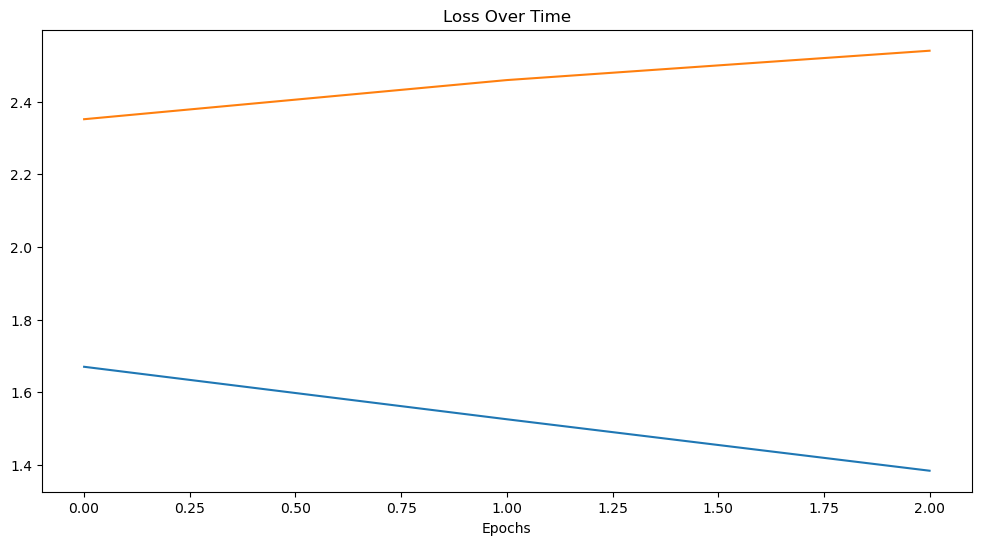

In [35]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')

In [38]:
def predict_rating(title, overview):
    # Tokenize and pad the title and overview
    title_sequence = tokenizer.texts_to_sequences([title])
    padded_title = pad_sequences(title_sequence, maxlen=100)

    overview_sequence = tokenizer.texts_to_sequences([overview])
    padded_overview = pad_sequences(overview_sequence, maxlen=500)

    # Predict the rating
    predicted_rating = model.predict([padded_title, padded_overview])

    return predicted_rating[0][0]

In [39]:
# Test the function with a new movie title and overview
new_title = "The Adventure Begins"
new_overview = "A group of friends embark on a fun adventure determined to find a college roommate who disappeared without a trace on graduation day."
predicted_rating = predict_rating(new_title, new_overview)

print(f"The predicted rating for the movie with the title '{new_title}' and the following overview:\n\n{new_overview}\n\nis {predicted_rating}")

1/1 [==============================] - 1s 595ms/step
The predicted rating for the movie with the title 'The Adventure Begins' and the following overview:

A group of friends embark on a fun adventure determined to find a college roommate who disappeared without a trace on graduation day.

is 6.276324272155762
